In [2]:
import arcpy
import numpy as np
import time

DBPATH=r"C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\FL_Zone_9a_9b_Scrub_Incursion_Restoration\FL_Zone_9a_9b_Scrub_Incursion_Restoration.gdb"
DATA_PATH=r"C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data"

arcpy.env.workspace=DBPATH


demFile = r"%s\flidar_mosaic_m\flidar_mosaic_m.gdb\flidar_mosaic_m" % DATA_PATH
spatialRef = arcpy.Describe(demFile).spatialReference
defaultGridSz = 25


In [62]:
#Create Extent Feature.  This is the overlay of the DRASTIC and Subsurface Geological Data
waterTbl = r"%s\DRASTIC_for_the_Surficial_Aquifer\DRASTIC_for_the_Surficial_Aquifer.shp" % DATA_PATH
subSurfaceGeog =  r"%s\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY" % DATA_PATH

#This will make sure we aren't selecting data from the panhandle
initMaskExtent = "404732.2623999994 334500.8658999996 697135.871199999 733658.6742000002"

#Get the intersection of the two
with arcpy.EnvManager(outputCoordinateSystem=spatialRef, 
                                              parallelProcessingFactor="75%", 
                                              extent=initMaskExtent):
    arcpy.analysis.Intersect([subSurfaceGeog, 'zone9'], 'zoneGeog_isect', 'ONLY_FID')

#Note: The extent gets reduced further...
with arcpy.EnvManager(outputCoordinateSystem=spatialRef, 
                                              parallelProcessingFactor="75%", 
                                              extent="MINOF"):
    arcpy.analysis.Intersect([waterTbl, 'zoneGeog_isect'], 'rfMaskFeature_isect', 'ONLY_FID') 

#Dissolve to remove boundaries for extent
arcpy.management.Dissolve('rfMaskFeature_isect', 'rfMaskFeature')
#Clean up
arcpy.management.Delete(r"'rfMaskFeature_isect'; 'zoneGeog_isect'")
arcpy.management.Delete(r"'rfMaskFeature_isect'; 'zoneGeog_isect'")



<Result 'true'>

In [2]:
#Get extent for future stuff
desc = arcpy.Describe('rfMaskFeature')
xmin = desc.extent.XMin
xmax = desc.extent.XMax
ymin = desc.extent.YMin
ymax = desc.extent.YMax
rfMaskExtent="%s %s %s %s" % (xmin, ymin, xmax, ymax)

In [6]:
#Create a snap raster/mask raster from the extent feature
with arcpy.EnvManager(outputCoordinateSystem=spatialRef,
                      pyramid="NONE", 
                      cellSize=defaultGridSz):
    arcpy.conversion.FeatureToRaster('rfMaskFeature', "OBJECTID", "rfMaskRaster", defaultGridSz)


In [7]:
def fillRaster(inRaster):
    
    prop = arcpy.GetRasterProperties_management(inRaster, "MINIMUM")
    minVal = int(prop.getOutput(0))
    prop = arcpy.GetRasterProperties_management(inRaster, "MAXIMUM")
    maxVal = int(prop.getOutput(0))
    prop = arcpy.GetRasterProperties_management(inRaster, "VALUETYPE") 
    valType = int(prop.getOutput(0))

    valueRange = {  0 : (0,1),
                    1 : (0, 3),
                    2 : (0, 15),
                    3 : (0, 255),
                    4 : (-128, 127),
                    5 : (0, 65535),
                    6 : (-32768, 32767),
                    7 : (0, 42949672957),
                    8 : (-2147483648, 21474836477),
                    9 : (-3.402823466e+38 , 3.402823466e+38),
                    10 : (0, 18446744073709551616)
                 }
    try:
        minMax = valueRange[valType]
    except:
        print("This value %s is likely complex. Consider another way." % valType )


    if minVal > minMax[0]:
        nullValue = minMax[0]
    elif maxVal < minMax[1]:
        nullValue = minMax[1]
    else:
        nullValue = 0

    print("Setting null values in raster %s to: %s" % (inRaster, nullValue))    
    
    with arcpy.EnvManager(outputCoordinateSystem=spatialRef, extent=rfMaskExtent):
        filledRaster = arcpy.sa.Con(arcpy.sa.IsNull(inRaster), nullValue, inRaster, "Value = 1")  

    return filledRaster

In [8]:
#Copy Raster Function.  This will copy a raster to the database with the defined paramters for the rf
def rfCopyMaskedRaster(inRaster, outName):
    filledRaster = fillRaster(inRaster)

    with arcpy.EnvManager(outputCoordinateSystem=spatialRef, 
                      snapRaster='rfMaskRaster', 
                      cellSize='rfMaskRaster', 
                      mask="rfMaskRaster"):
        
        maskedRaster = arcpy.sa.ExtractByMask(filledRaster, "rfMaskRaster");
        maskedRaster.save(outName)        

In [9]:
def update_subsurface_epoch():
    infile=r"%s\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY" % DATA_PATH
    
    arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")
    
    time.sleep(2)
    
    field="GEOLOGIC_HISTORY"
    
    with arcpy.da.UpdateCursor(infile, (field,)) as cursor:
        for row in cursor:
            try:
                row[0]=row[0].replace(" ", "")
                row[0]=row[0].upper()
            except:
                row[0]=""

            cursor.updateRow(row)
    
    arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")


In [10]:
#This expands the lithology field in the FGS_STATEMAP_GEOLOGY feature and updates the table so 
# attributes can be mapped accurately
#The original file only contains this information as a comma delimited list in an attribute field,
# in natural languge, with mixed order, case, and plurality (e.g. "shells, organic" in one attribute
# and then "organics, Shell" in another). This fixes the language for uniformity
# and updates the table with binary indicators for the varous lithologites.

def update_lithology_attributes():
    infile=r"%s\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY" % DATA_PATH
    arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")

    geogTbl = arcpy.da.TableToNumPyArray (infile, 'Lithology', skip_nulls=True)
    lithos = set()

    #Find the various lithologies and fix 
    for lithology in geogTbl["Lithology"]:
        try: 
            lithology = lithology.lower()
            lithology = lithology.replace(" ", "")
            lithology = lithology.replace("s,", ",")
            if lithology[-1] == 's': lithology = lithology[:-1]
        except:
            continue
        
        lithos = lithos | set(lithology.split(','))
        
    arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")

    #should be {'organic', 'sand', 'phosphate', 'dolostone', 'shell', 'heavymineral', 'clay', 'limestone'}
    print("Adding Fields:",  lithos)

    for litho in lithos:
        arcpy.AddField_management(infile, litho, "SHORT")
        print("Adding Field %s" % litho)

    fields=['Lithology']
    fields.extend(list(lithos))

    fieldMap = {fields[x] : x for x in range(len(fields))}
    print("Mapping field indexes:", fieldMap)
    
    with arcpy.da.UpdateCursor(infile, fields) as cursor:
        for row in cursor:
            print("Row in", row)
            try: 
                row[1:] = [0] * (len(row) - 1)

                lithology = row[fieldMap['Lithology']] 
                lithology = lithology.lower()
                lithology = lithology.replace(" ", "")
                lithology = lithology.replace("s,", ",")
                if lithology[-1] == 's': lithology = lithology[:-1]

            except:
                cursor.updateRow(row)
                continue


            for soil in lithology.split(','):
                row[fieldMap[soil]] = 1

            print("Row out", row)
            #Update the cursor with the updated list
            cursor.updateRow(row)

    arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")


In [11]:
#Copy Feature Function.  This will copy a reature to the database with the defined paramters for the rf
def rfFeatureToRaster(inFeature, rasterField, outName):
    tempFeature = "%s_temp" % outName
    arcpy.management.Delete(tempFeature)

    print(inFeature)
    print(tempFeature)

    #ArcGIS is acting weird, claiming features aren't 
    arcpy.management.SelectLayerByAttribute(inFeature, "CLEAR_SELECTION")

    arcpy.analysis.Intersect([inFeature, 'rfMaskFeature'], tempFeature) 
    
    with arcpy.EnvManager(outputCoordinateSystem=spatialRef, 
                      snapRaster="rfMaskRaster", 
                      pyramid="NONE", 
                      extent="DEFAULT"):
        
        
        arcpy.conversion.FeatureToRaster(tempFeature, rasterField, outName, defaultGridSz)
    
    arcpy.management.Delete(tempFeature)


In [87]:
#Create Feature with Psudo-Absence Data for Scrub

infile=r"%s\FL_Classified_Land_Cover.gdb\CLC_v3_4_poly" % DATA_PATH
arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")

polys = arcpy.da.TableToNumPyArray (infile, 'NAME_SITE', skip_nulls=True)



listOfSites = list(np.unique(polys['NAME_SITE']))

#Generate List of Absense Sites
absenceSites = set()
exludedTerms = ["Marsh", "Swamp", "Marine", "Floodplain", "Wetland", "Surf", "Cutthroat"]
for exludedTerm in exludedTerms:
    absenceSites = absenceSites | set([s for s in listOfSites if exludedTerm in s])

print("Absense Sites:", absenceSites)    
    
#Build SQL Query
ppaSelQueary=""
for absenceSite in absenceSites:
    ppaSelQueary = ppaSelQueary + str("NAME_SITE = \'%s\' Or " % absenceSite)

#Add Presense Data to Query    
ppaSelQueary = ppaSelQueary + "NAME_SITE = \'Scrub\'"

#Select by Attribute
ppaScrub = arcpy.management.SelectLayerByAttribute(infile, 
                                    where_clause = ppaSelQueary)


arcpy.analysis.Intersect([ppaScrub, 'zone9'], 'ppaScrubZone9')
arcpy.management.Delete(ppaScrub)


with arcpy.EnvManager(outputCoordinateSystem=spatialRef, extent=rfMaskExtent):
     arcpy.gapro.OverlayLayers('ppaScrubZone9', 
                               'rfMaskFeature', 
                               'ppa_scrub_training_features', 
                               overlay_type = 'INTERSECT')


####Cleanup
arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")

arcpy.AddField_management(infile, "Presence", "SHORT")

with arcpy.da.UpdateCursor(infile, ["NAME_SITE", "Presence"]) as cursor:
    for row in cursor:
        if row[0] == "Scrub":
            row[1] = 1;
        else:
            row[1] = 0;
        
        cursor.updateRow(row)


Absense Sites: %s {'Mixed Hardwood Coniferous Swamps', 'Clearcut Wetland', 'Strand Swamp', 'Grazed Wetlands', 'Freshwater Tidal Marsh', 'Cypress/Hardwood Swamps', 'Non-vegetated Wetland', 'Isolated Freshwater Swamp', 'Depression Marsh', 'Basin Swamp', 'Marine', 'Slough Marsh', 'Dome Swamp', 'River Floodplain Lake/Swamp Lake', 'Isolated Freshwater Marsh', 'Impounded Swamp', 'Titi Swamp', 'Floodplain Swamp', 'Mixed Wetland Hardwoods', 'Other Coniferous Wetlands', 'Surf Zone', 'Marshes', 'Exotic Wetland Hardwoods', 'Other Hardwood Wetlands', 'Mixed Scrub-Shrub Wetland', 'Floodplain Marsh', 'Mangrove Swamp', 'Flatwoods/Prairie/Marsh Lake', 'Impounded Marsh', 'Freshwater Tidal Swamp', 'Bay Swamp', 'Cutthroat Seep', 'Salt Marsh', 'Cutthroat Grass Flatwoods', 'Basin Marsh', 'Glades Marsh'}


id,value
0,a Layer object
1,-1


In [95]:
print("Status for training data")

arcpy.management.SelectLayerByAttribute('ppa_scrub_training_features', "CLEAR_SELECTION")
arcpy.management.SelectLayerByAttribute('ppaScrubZone9', "CLEAR_SELECTION")

areas = arcpy.da.TableToNumPyArray ('ppaScrubZone9', 'SHAPE_Area', skip_nulls=True)
originalDataArea = areas["SHAPE_Area"].sum()
print("Original Area %s m^2"  % originalDataArea)

areas = arcpy.da.TableToNumPyArray ('ppa_scrub_training_features', 'SHAPE_Area', skip_nulls=True)
maskedDataArea = areas["SHAPE_Area"].sum()
print("Area after Masking %s m^2"  % maskedDataArea)

knownScrubZone9 = arcpy.management.SelectLayerByAttribute('ppa_scrub_training_features', 
                                                            where_clause = "NAME_SITE = \'Scrub\'")

areas = arcpy.da.TableToNumPyArray (knownScrubZone9, 'SHAPE_Area', skip_nulls=True)
presenceDataArea = areas["SHAPE_Area"].sum()
print("Area of presence data in  %s m^2"  % presenceDataArea)

knownScrubZone9Area = areas["SHAPE_Area"].sum()
print("Original Area %s m^2"  % originalDataArea)

maskedPct = 100 * (maskedDataArea/originalDataArea)
print("Percentage of original area after masking %s%%" % maskedPct)

paRatio = 100 * (presenceDataArea/maskedDataArea)
print("Percentage of presence data in study area %s%%" % paRatio)

arcpy.management.SelectLayerByAttribute('ppa_scrub_training_features', "CLEAR_SELECTION")
arcpy.management.SelectLayerByAttribute('ppaScrubZone9', "CLEAR_SELECTION")


Status for training data
Original Area 19676993400.453903 m^2
Area after Masking 7618399431.353587 m^2
Area of presence data in  387671294.5828786 m^2
Original Area 19676993400.453903 m^2
Percentage of original area after masking 38.71729423448324%
Percentage of presence data in study area 5.0886186537741%


id,value
0,a Layer object
1,-1


In [12]:
#Create Clipped Rasters from Raster
rasters = []

rasters.append((r"%s\flidar_mosaic_m\flidar_mosaic_m.gdb\flidar_mosaic_m" % DATA_PATH, 
                  "rf_dem"))

for raster in rasters:
    rfCopyMaskedRaster(raster[0], raster[1])
    
#Create Slope from Elevation.  This will take a few minutes.
out_raster = arcpy.sa.Slope('rf_dem', method = "GEODESIC")
out_raster.save('rf_slope')



Setting null values in raster C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Aquifer_Recharge\Aquifer_Recharge_v4_1\recharge_v41 to: 15
Setting null values in raster C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Natural_Floodplain_v4_4\Natural_Floodplain_v4_4\floodpl_v44 to: 15
Setting null values in raster C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Significant_Surface_Waters\Significant_Surface_Waters_v4_1\surfwatr_v41 to: 15
Setting null values in raster C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Wetlands\Functional_Wetlands_v4_4\wetlands_v44 to: 15


In [ ]:
#update_lithology_attributes()
#update_subsurface_epoch()

In [13]:
#Create Rasters from Features
geog_infile=r"%s\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY" % DATA_PATH

geog_fields = ['GEOLOGIC_HISTORY', 
                   'organic', 
                   'sand', 
                   'phosphate', 
                   'dolostone', 
                   'shell', 
                   'heavymineral', 
                   'clay', 
                   'limestone']

for geog_field in geog_fields:
    rasterName="rf_subsurface_geog_%s" % geog_field
    rfFeatureToRaster(geog_infile, geog_field, rasterName)

features=[]
features.append(("%s/USDA_NRCS_Soils/nrcs_soils_sep18.shp" % DATA_PATH, 
                "DRAINAGECL", 
                "rf_drainage"))

features.append(("%s/USDA_NRCS_Soils/nrcs_soils_sep18.shp" % DATA_PATH, 
                 "MUKEY", 
                 "rf_top_soil_detail"))


features.append((r"%s\USDA_FL_Soil\spatial\gsmsoilmu_a_fl.shp" % DATA_PATH, 
                "MUKEY", 
                "rf_top_soil"))

features.append((r"%s\DRASTIC_for_the_Surficial_Aquifer\DRASTIC_for_the_Surficial_Aquifer.shp" % DATA_PATH, 
                 "DW", 
                 "rf_water_table_depth"))


features.append(("%s/USDA_NRCS_Soils/nrcs_soils_sep18.shp" % DATA_PATH, 
                "FLODFREQMA", 
                "rf_flooding"))

features.append((r"%s\DRASTIC_for_the_Surficial_Aquifer\DRASTIC_for_the_Surficial_Aquifer.shp" % DATA_PATH, 
                 "HC", 
                 "rf_hydraulic_conductivity"))

for feature in features:
    rfFeatureToRaster(feature[0], feature[1], feature[2])



    

C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY
rf_subsurface_geog_GEOLOGIC_HISTORY_temp
C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY
rf_subsurface_geog_organic_temp
C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY
rf_subsurface_geog_sand_temp
C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY
rf_subsurface_geog_phosphate_temp
C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY
rf_subsurface_geog_dolostone_temp
C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY
rf_subsurface_geog_shell_temp
C:\Users

In [12]:
features=[]
features.append(("%s/USDA_NRCS_Soils/nrcs_soils_sep18.shp" % DATA_PATH, 
                "TEXTURE", 
                "rf_texture"))

features.append(("%s/USDA_NRCS_Soils/nrcs_soils_sep18.shp" % DATA_PATH, 
                "HYDRICRATI", 
                "rf_hydric"))
for feature in features:
    rfFeatureToRaster(feature[0], feature[1], feature[2])

C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data/USDA_NRCS_Soils/nrcs_soils_sep18.shp
rf_texture_temp
C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data/USDA_NRCS_Soils/nrcs_soils_sep18.shp
rf_hydric_temp


In [13]:
features=[]
features.append(("%s/USDA_NRCS_Soils/nrcs_soils_sep18.shp" % DATA_PATH, 
                "HYDRGRP", 
                "rf_hdg"))
for feature in features:
    rfFeatureToRaster(feature[0], feature[1], feature[2])

C:\Users\mike\Documents\OSU\GEOG561\Project - Florida Scrub Zone\Data/USDA_NRCS_Soils/nrcs_soils_sep18.shp
rf_hdg_temp


In [ ]:
geog_infile=r"%s\FL_Soil_Geology\FGS_STATEMAP_GEOLOGY.gdb\FGS_STATEMAP_GEOLOGY" % DATA_PATH

geog_fields = ['GEOLOGIC_HISTORY', 
                   'organic', 
                   'sand', 
                   'phosphate', 
                   'dolostone', 
                   'shell', 
                   'heavymineral', 
                   'clay', 
                   'limestone']

    
for geog_field in geog_fields:
    rasterName="rf_subsurface_geog_%s" % geog_field
    rfFeatureToRaster(geog_infile, geog_field, rasterName)



In [113]:
infile = r"%s\DRASTIC_for_the_Surficial_Aquifer\DRASTIC_for_the_Surficial_Aquifer.shp" % DATA_PATH

for field in arcpy.ListFields(infile):
    print(field.name)

FID
Shape
PERIMETER
SETTING
DW
NR
AM
SM
T
IV
HC
DWV
NRV
AMV
SMV
TV
IVV
HCV
INDEX_X
OBJECTID
DEP_DRASTI
SHAPEAREA
SHAPELEN


In [51]:
#Create water table depth raster
infile=r"%s\DRASTIC_for_the_Surficial_Aquifer\DRASTIC_for_the_Surficial_Aquifer.shp" % DATA_PATH
arcpy.management.SelectLayerByAttribute(infile, "CLEAR_SELECTION")

arcpy.conversion.FeatureToRaster(infile, "DW", "water_table_depth", 15)

<Result 'C:\\Users\\mike\\Documents\\OSU\\GEOG561\\Project - Florida Scrub Zone\\FL_Zone_9a_9b_Scrub_Incursion_Restoration\\FL_Zone_9a_9b_Scrub_Incursion_Restoration.gdb\\water_table_depth'>

In [125]:
arcpy.AddField_management("ppa_scrub_training_features", "Presence", "SHORT")

with arcpy.da.UpdateCursor("ppa_scrub_training_features", ["NAME_SITE", "Presence"]) as cursor:
    for row in cursor:
        if row[0] == "Scrub":
            row[1] = 1;
        else:
            row[1] = 0;
        
        cursor.updateRow(row)


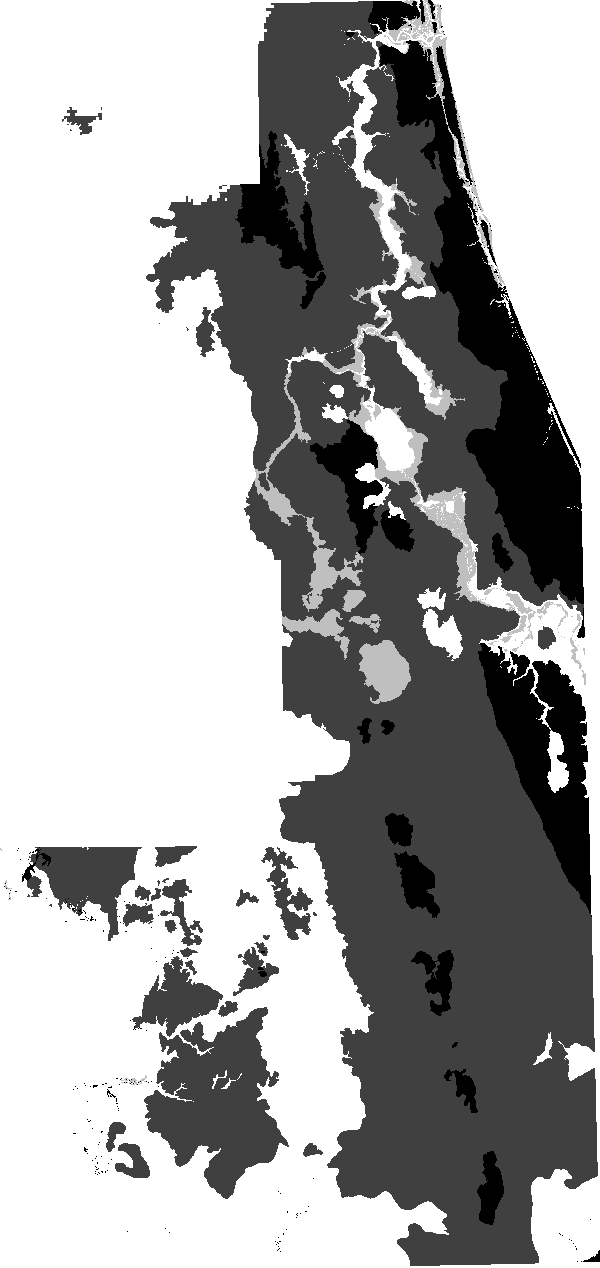

In [22]:
subsurf_names = [  'rf_subsurface_geog_organic', 
                   'rf_subsurface_geog_sand', 
                   'rf_subsurface_geog_phosphate', 
                   'rf_subsurface_geog_dolostone', 
                   'rf_subsurface_geog_shell', 
                   'rf_subsurface_geog_heavymineral', 
                   'rf_subsurface_geog_clay', 
                   'rf_subsurface_geog_limestone']


rasters=[]


for subsurf_name in subsurf_names:
    rasters.append(arcpy.Raster(subsurf_name))

iterator = 1

rf_subsurface_geog_comp = rasters[0]

for raster in rasters[1:]:
    rf_subsurface_geog_comp = rf_subsurface_geog_comp + (raster * (2**iterator))
    iterator = iterator+1

rf_subsurface_geog_comp

In [23]:
rf_subsurface_geog_comp.save("rf_subsurface_geog_comp")

In [27]:
#Get CS observations from known zone9 scrub lands from CLC
arcpy.management.AddField("csScrubCommunityPa", "Presence", "SHORT", )
arcpy.management.CalculateField("csScrubCommunityPa", "Presence", "0", "PYTHON3", '', "TEXT")
arcpy.analysis.Intersect(['csScrubCommunityPa', 'rfMaskFeature'], 'pa_scrub_community') 



<Result 'C:\\Users\\mike\\Documents\\OSU\\GEOG561\\Project - Florida Scrub Zone\\FL_Zone_9a_9b_Scrub_Incursion_Restoration\\FL_Zone_9a_9b_Scrub_Incursion_Restoration.gdb\\pa_scrub_community'>

In [28]:
#Get CS observations from known zone9 scrub lands from CLC
arcpy.management.AddField("csScrubPlantsZone9Communities", "Presence", "SHORT", )
arcpy.management.CalculateField("csScrubPlantsZone9Communities", "Presence", "1", "PYTHON3", '', "TEXT")
arcpy.analysis.Intersect(['csScrubPlantsZone9Communities', 'rfMaskFeature'], 'p_scrub_community') 


<Result 'C:\\Users\\mike\\Documents\\OSU\\GEOG561\\Project - Florida Scrub Zone\\FL_Zone_9a_9b_Scrub_Incursion_Restoration\\FL_Zone_9a_9b_Scrub_Incursion_Restoration.gdb\\p_scrub_community'>

In [29]:
arcpy.management.Merge(["p_scrub_community", "pa_scrub_community"], "ppa_cs_scrub_community")

<Result 'C:\\Users\\mike\\Documents\\OSU\\GEOG561\\Project - Florida Scrub Zone\\FL_Zone_9a_9b_Scrub_Incursion_Restoration\\FL_Zone_9a_9b_Scrub_Incursion_Restoration.gdb\\ppa_cs_scrub_community'>